<a href="https://colab.research.google.com/github/skylerlewis/nwca-wetland-remote-sensing/blob/main/nwca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NWCA Comparison Study - Working Document

**key variables**:
- traits
    - Δ `CN_Ratio` = Carbon:Nitrogen Ratio
    - Δ `AnaerobicTol_Mean` = Anaerobic Tolerance
    - Δ `SLA_Mean` = Specific Leaf Area
    - Δ `XRCOV_NATSPP` & `XRCOV_ALIENSPP` = % cover native and non-native species
- species diversity
    - Δ `NSPP` = species richness
    - Δ `ShannonDiv` = Shannon index
- functional diversity
    - Δ `SLA_Variance` = Specific Leaf Area variance
- stability
    - time series covariates
        - `NumPeaks`
        - `MaxPSD`
    - phenological variability (`pheno_var`) = Proxy of the inter-annual variation in NDVI over 2007-2016 (low values = more stable, high values = more variable)
    - traditional stability measures: changes in greenness metrics (`MV_*_Mean`, `MV_*_Max`)
- climate
    - *long term averages*: temp, ppt
    - Δ`ppt_std` = (change in) climate variability
    - `aet_mean` and `def_mean` (AET and [climate water deficit](https://www.fs.fed.us/psw/cirmount/meetings/agu/pdf2011/Stephenson_talk_AGU2011.pdf)) 
- fixed attributes
    - `WetlandType` or simpler four-level `WetlandCat`
    - `d_estuarine`: palustrine/lacustrine/riverine (0) or estuarine (1)
    - `d_woody`: herbaceous (0) or woody (1)
    - `ecoregion` = four-level NWCA ecoregion categories

**models**:
- Δdiversity ~ Δtraits + Δclimate + attributes
- Δstability ~ Δdiversity + Δtraits + Δclimate + attributes

**models**: 
- CHANGE IN DIVERSITY: Δ`NSPP`, Δ`ShannonDiv` ~ 
    - changes in functional traits (Δ`SLA_Mean`, Δ`CN_Ratio`, Δ`AnaerobicTol_Mean`)
    - changes in non-native plant cover (Δ`XRCOV_NATSPP`)
    - changes in climate of sample years (Δ`PDSI_mean` or Δ`def_mean` or Δ`def_max`)
    - ~~climate of sample years (`def_mean_*` and `aet_mean_*`)~~
    - controls for wetland type (`d_estuarine`, `d_woody`)
- STABILITY: `MV_*_Mean`, `MV_*_Max`, `pheno_var` ~ 
    - time series covariates (`NumPeaks`, `MaxPSD`)
    - changes in taxonomic diversity (Δ`NSPP`, Δ`ShannonDiv`)
    - changes in functional diversity (Δ`SLA_Variance`)
    - intraannual climatic variation (`def_std_*`)
    - *plus covariates from diversity model:*
    - change in functional traits (Δ`SLA_Mean`, Δ`CN_Ratio`, Δ`AnaerobicTol_Mean`)
    - changes in non-native plant cover (Δ`XRCOV_NATSPP`)
    - changes in climate of sample years (Δ`PDSI_mean` or Δ`def_mean` or Δ`def_max`)
    - ~~climate of sample years (`def_mean_*` and `aet_mean_*`)~~
    - controls for wetland type (`d_estuarine`, `d_woody`)


**roadmap**
- data import and exploration
- simple OLS models
- formal model selection (see paper)
- diagnostics (residuals, spatial autocorrelation)
- non-linear methods (e.g. Random Forest regression, SEM?)

# Environment setup

Install packages (these are the packages that are not available on the Google cloud servers)

In [ ]:
# install packages in the virtual environment
# if there are errors, force restart the environment (factory reset runtime)
!pip install -q pandas fiona shapely pyproj rtree pygeos #--upgrade --force-reinstall
!pip install -q geopandas #--upgrade --force-reinstall
!pip install -q rasterio rioxarray
!pip install -q -U PyDrive
!pip install pysal

     |████████████████████████████████| 15.4MB 184kB/s 
     |████████████████████████████████| 6.6MB 28.0MB/s 
     |████████████████████████████████| 1.0MB 44.2MB/s 
     |████████████████████████████████| 2.0MB 40.7MB/s 
     |████████████████████████████████| 1.0MB 25.5MB/s 
     |████████████████████████████████| 19.3MB 4.6MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# setup for accessing files via Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # opens auth prompt the first time it's run
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def file_from_gdrive(filename, driveid):
    downloaded = drive.CreateFile({"id": driveid}) 
    downloaded.GetContentFile(filename)
    return filename

# mount files from google drive (after running, they will be accessible by filename without any path prefix)
file_from_gdrive("Site_comparison_2011_2016.csv", "1PoYS_fbE1lYwi3ydbpXKkuP8YqoBFjnf")
file_from_gdrive("README.csv", "1G5l8L2FgM0EebEKbjy06OWdsfGs47i3c")
file_from_gdrive("Aggr_Ecoregions_2015.zip", "1UqUM1mrj6qptAxSY8c1OGc3zRP_p7bVM")
file_from_gdrive("SubDataset_NWCA_2011.csv", "1QFbR0NoFo7go9hXp690yvb1_G-FjJTUV")
file_from_gdrive("RS_stability_NDVI_7_15_21.csv", "1-0dqvcgYokChh0dVZS8f7S7AfHVXr5pE")
# alternately, mount google drive and access via "/content/drive/MyDrive/nwca/filename..."

def unzip_shapefile(filename):
    import io
    from fiona.io import ZipMemoryFile
    zipshp = io.BytesIO(open(filename, "rb").read())
    with (ZipMemoryFile(zipshp)) as memfile:
        with memfile.open() as src:
            crs = src.crs
            gdf = gpd.GeoDataFrame.from_features(src, crs=crs)
    return gdf

# Package imports

In [ ]:
# basics
import os
import datetime as dt
from functools import reduce
import urllib
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# geospatial
import shapely
import geopandas as gpd 
import rasterio as rio
import xarray as xr 
import rioxarray
global_crs = "EPSG:5070" # NAD83 CONUS ALBERS

# statistical packages
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_squared_log_error

import pysal
from libpysal.weights import lat2W, KNN
from esda.moran import Moran

from pandas import IndexSlice as idx
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", '{:0.2f}'.format)

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom functions

In [ ]:
# function to keep only intersecting features
def subset_by_sindex(target_features, by_features, predicate="intersects") -> gpd.GeoDataFrame:
    """ Uses one geodataframe/geometry to query another. 
            Predicate is one of ['intersects', 'within', 'contains', 'overlaps', 'crosses', 'touches'] """
    inp, res = by_features.sindex.query_bulk(target_features.geometry, predicate=predicate)
    return target_features[np.isin(np.arange(0, len(target_features)), inp)]

# function to generate matplotlib colormap from list
def gen_cmap(palette: list) -> mpl.colors.LinearSegmentedColormap:
    """ Returns a matplotlib colormap given a list of color strings."""
    colors = [(i / (len(palette) - 1), x) for i, x in enumerate(palette)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", colors, len(palette))
    return cmap

def make_ellipse(x: np.ndarray, y: np.ndarray, n_std=3.0, type="confidence", **kwargs) -> mpl.patches.Ellipse:
    from scipy.stats import norm, chi2
    # calculate ellipse dimensions
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    if type == "confidence":
        # confidence ellipse
        q = 2 * norm.cdf(n_std) - 1
        r2 = chi2.ppf(q, 2)
        width, height = 2 * np.sqrt(vals * r2)
    elif type == "error":
        # error ellipse
        width, height = 2 * n_std * np.sqrt(vals)
    #print(width, height, theta)
    # center of ellipse
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # create ellipse
    ellipse = mpl.patches.Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=theta, **kwargs)
    return ellipse

def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = ['_'.join(tup).rstrip('_') for tup in d.columns.values]
    return d

def quick_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor 
    v = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return pd.Series(v, index = df.columns)

def quick_skedplot(modelfit, title=None):
    pred_mod = modelfit.predict()
    res_mod = modelfit.resid
    fig, ax = plt.subplots(figsize=(10,6))
    x = pred_mod
    y = res_mod
    if title is None:
        plt.title("Homoskedasticity Test Plot")
    else:
        plt.title(title)
    plt.axhline(y=0, color="black", linestyle=":") 
    ax.scatter(x, y)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")  
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))
    sns.despine(trim=True)
    plt.show()

def quick_skedtest(models: list, labels=None):
    from statsmodels.compat import lzip
    from statsmodels.stats.diagnostic import het_breuschpagan
    test_names = ['LMS', 'P(LMS)', 'F', 'P(F)']
    t = []
    for m in models:
        results = het_breuschpagan(m.resid, m.model.exog)
        t.append([x for x in results])
        #print(lzip(test_names, results))
    if labels is None:
        return pd.DataFrame(t, columns=test_names)
    else:
        return pd.DataFrame(t, columns=test_names, index=labels)

def plot_actual_vs_predicted(actual: np.ndarray, predicted: np.ndarray, n_std: int = 2, **kwargs) -> sns.axisgrid.FacetGrid:
    g = sns.jointplot(x=actual, y=predicted, **kwargs)
    std_min = min(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_max = max(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_lim = (std_min, std_max)
    g.ax_joint.set_xlim(std_lim)
    g.ax_joint.set_ylim(std_lim)
    g.ax_marg_x.set_xlim(std_lim)
    g.ax_marg_y.set_ylim(std_lim)
    sns.despine(trim=True, ax=g.ax_joint)
    sns.despine(trim=True, ax=g.ax_marg_x, left=True)
    sns.despine(trim=True, ax=g.ax_marg_y, bottom=True)
    sns.lineplot(ax=g.ax_joint, color="black", linestyle=":", x=std_lim, y=std_lim)
    g.ax_joint.add_patch(make_ellipse(x=actual, y=predicted, 
            facecolor="#5799c6", alpha=0.2, type="error", n_std=n_std))
    return g

# Import site traits (NWCA) data from CSV

In [ ]:
# import data
sites = pd.read_csv("Site_comparison_2011_2016.csv")
readme = pd.read_csv("README.csv")

# convert to pandas datafrmae with multiindex (varname, year) derived from readme file
if (sites.columns == readme["trait"]).all():
    sites.columns = pd.MultiIndex.from_tuples(zip(readme["varname"], readme["year"]), names=["varname", "year"])
else:
    raise ValueError("Make sure the list of variables in both files matches!")

# create ID for the 
# sites["id"] = sites[("UID", "2011")].astype(str) + "-" + sites[("UID", "2016")].astype(str)
# sites = sites.set_index("id")
sites = sites.set_index([("UID", "2011"), ("UID", "2016")]).rename_axis(["UID11", "UID16"])

# cast species richness to integer
#sites["NSPP"] = sites["NSPP"].astype(pd.Int64Dtype())

# create order for wetland types
wetlandtypes = ["PFO", "PSS", "PEM", "PUBPAB", "E2SS", "E2EM"]
typecolors = ["#55AD89", "#C3BC3F", "#FFAE34", "#BAA094", "#8CC2CA", "#6388B4"]
sites[("WetlandType", "2011")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2011")]]
sites[("WetlandType", "2016")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2016")]]
sites[("WetlandType", "2011")] = sites[("WetlandType", "2011")].astype("category").cat.set_categories(wetlandtypes)
sites[("WetlandType", "2016")] = sites[("WetlandType", "2016")].astype("category").cat.set_categories(wetlandtypes)

# wetland general categories
wetlandcats = ["EH", "EW", "PRLH", "PRLW"] # Estuarine herbaceous & woody, Palustrine/Riverine/Lacustrine herbaceous & woody
catcolors = ["#8CC2CA", "#6388B4", "#C3BC3F", "#55AD89"]
sites[("WetlandCat", "2011")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2011")] = sites[("WetlandCat", "2011")].astype("category").cat.set_categories(wetlandcats)
sites[("WetlandCat", "2016")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2016")] = sites[("WetlandCat", "2016")].astype("category").cat.set_categories(wetlandcats)

# create dummies for estuarine and woody
#sites["WetlandCat"].applymap(lambda x: x[-1]=="W")
#sites["WetlandCat"].applymap(lambda x: x[:-1]=="E")
for yr in ["2011", "2016"]:
    sites[("d_estuarine", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[:-1]=="E"), 1, 0)
    sites[("d_woody", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[-1]=="W"), 1, 0)
    # total coverage and proportion of which is native
    sites[("XRCOV", yr)] = sites[("XRCOV_NATSPP", yr)] + sites[("XRCOV_ALIENSPP", yr)] 
    sites[("XRCOV_PropNative", yr)] = sites[("XRCOV_NATSPP", yr)] / sites[("XRCOV", yr)]

# logs of variables that are right tailed
vars_to_log = ["NSPP", "SLA_Mean", "AnaerobicTol_Mean", "CN_Ratio", "XN_NATSPP", "XN_ALIENSPP", "XRCOV_ALIENSPP"]
for v in vars_to_log:
    for y in ["2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

# import the second dataset
ds11 = pd.read_csv("SubDataset_NWCA_2011.csv").set_index("UID").rename_axis("UID11")
ds11.columns = pd.MultiIndex.from_tuples([(x, "2011") for x in ds11.columns])
sites = sites.join(ds11, how="left")

# create dummies for disturbance level, and also change it to an ordered category
sites[("REF_NWCA", "2011")] = sites[("REF_NWCA", "2011")].astype("category").cat.set_categories(["L", "I", "M"])#.cat.rename_categories(["Least", "Intermediate", "Most"])
sites[("d_disturb_L", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="L", 1, 0)
sites[("d_disturb_I", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="I", 1, 0)
sites[("d_disturb_M", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="M", 1, 0)

# import the remote sensing stability dataset
dsstab = pd.read_csv("RS_stability_NDVI_7_15_21.csv").set_index("siteID").rename_axis("UID11")
dsstab.columns = pd.MultiIndex.from_tuples([(x, "") for x in dsstab.columns])
sites = sites.join(dsstab, how="left")

# harmonic means of mean:variance ratios for NDVI (avg values derived from 3 platforms)
sites[("MV_all_Mean", "")] = 3 / (1/sites["MV_ModTerra_Mean"] + 1/sites["MV_ModAqua_Mean"] + 1/sites["MV_Landsat_Mean"])
sites[("MV_all_Max", "")] = 3 / (1/sites["MV_ModTerra_Max"] + 1/sites["MV_ModAqua_Max"] + 1/sites["MV_Landsat_Max"])

# log the pheno var
sites[("log_pheno_var", "")] = np.log(sites["pheno_var"])
sites[("log_MaxPSD", "")] = np.log(sites["MaxPSD"])
sites[("log_MV_all_Mean", "")] = np.log(sites["MV_all_Mean"])

sites

varname      Latitude Longitude Latitude  ... Unnamed: 11 MV_all_Mean MV_all_Max
year             2011      2011     2016  ...                                   
UID11 UID16                               ...                                   
2610  204253    30.15    -85.04    30.15  ...         nan       15.58      20.79
2611  201075    32.53    -80.45    32.53  ...         nan       13.82       6.62
2669  197720    29.66    -81.77    29.66  ...         nan       22.38      25.83
2791  200920    32.39    -80.66    32.39  ...         nan       24.44      13.62
2812  197200    30.26    -87.73    30.26  ...         nan       10.27      11.47
...               ...       ...      ...  ...         ...         ...        ...
5910  209080    47.55    -95.59    47.55  ...         nan       11.48      31.67
5911  204792    44.86    -72.05    44.86  ...         nan         nan        nan
5912  202530    43.91    -73.10    43.91  ...         nan       16.97      46.67
5915  202530    43.91    -73.10    43.91  ...         nan         nan        nan
6146  201931    31.56    -81.67    31.56  ...         nan       19.95      40.76

[293 rows x 130 columns]

In [ ]:
# example reshaping
sites.stack()

# examples subsetting the data by year

# data2011 = sites.loc[:, idx[:, "2011"]]
# data2011.columns = [x[0] for x in data2011.columns]
data2011 = sites.stack().loc[idx[:, :, "2011"]]

# data2016 = sites.loc[:, idx[:, "2016"]]
# data2016.columns = [x[0] for x in data2016.columns]
data2016 = sites.stack().loc[idx[:, :, "2016"]]

# Spatial data setup

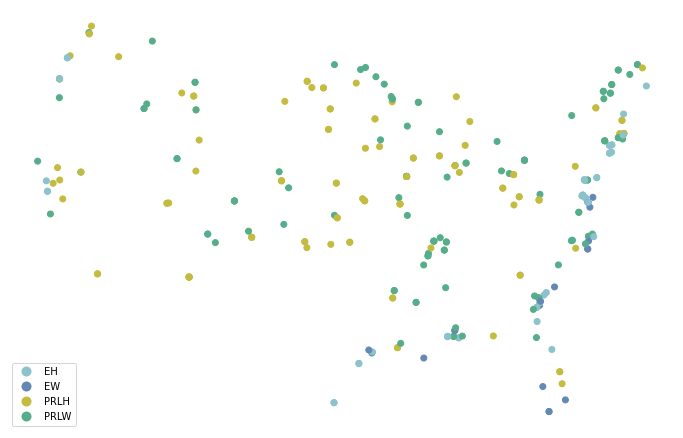

In [ ]:
# make geodataframe
sites_gdf = gpd.GeoDataFrame(sites.copy(), geometry=gpd.points_from_xy(sites[("Longitude", "2016")], sites[("Latitude", "2016")]))
# set existing CRS
sites_gdf[("geometry", "")].set_crs("EPSG:4269", inplace=True)
#sites_gdf.set_geometry(("geometry", ""), inplace=True)
# reproject
sites_gdf[("geometry", "")] = sites_gdf[("geometry", "")].to_crs(global_crs)
# set new CRS
#sites_gdf[("geometry", "")].set_crs(global_crs, inplace=True)
sites_gdf.set_geometry(("geometry", ""), inplace=True)

# plot result
fig, ax = plt.subplots()
sites_gdf.plot(column=("WetlandCat","2016"), legend=True, cmap=gen_cmap(catcolors), ax=ax)
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

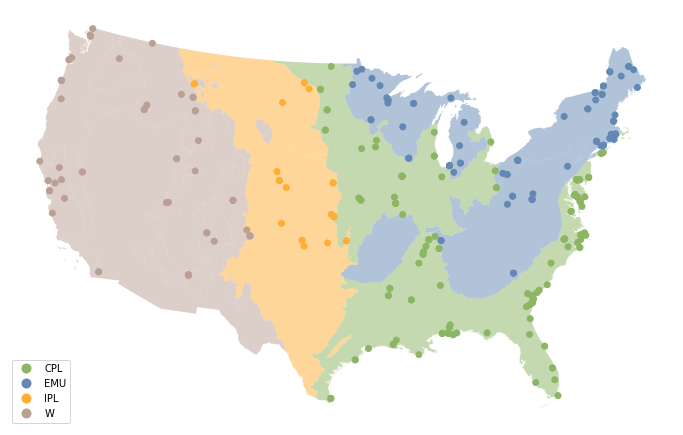

In [ ]:
# get ecoregions, convert from 9-level to 4-level for NWCA
#ecoregions = gpd.read_file(os.path.join("data", "ecoregions", "Aggr_Ecoregions_2015.shp")).to_crs(global_crs)
ecoregions = unzip_shapefile("Aggr_Ecoregions_2015.zip").to_crs(global_crs)
region_names = ["CPL", "EMU", "IPL", "W"]
region_colors = ["#8CB564", "#6388B4", "#FFAE34", "#BAA094"]
ecoregions["WSA4"] = ["EMU" if x in ["NAP", "SAP", "UMW"]
                        else "IPL" if x in ["NPL", "SPL"]
                        else "W" if x in ["XER", "WMT"]
                        else "CPL" for x in ecoregions["WSA9"]]
ecoregions["WSA4"] = ecoregions["WSA4"].astype("category").cat.set_categories(region_names)
points = gpd.GeoDataFrame(flatten_columns(gpd.GeoDataFrame(sites_gdf.geometry.copy())), crs=sites_gdf.geometry.crs)
site_regions = gpd.sjoin(points, ecoregions, how="left", op="within")

# plot ecoregions by site
fig, ax = plt.subplots()
ecoregions.plot(column="WSA4", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors))
site_regions.plot(column="WSA4", ax=ax, legend=True, cmap=gen_cmap(region_colors))
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

# add to site table
sites["ecoregion"] = site_regions["WSA4"]

In [ ]:
# TERRACLIMATE
# catalog: http://thredds.northwestknowledge.net:8080/thredds/catalog/TERRACLIMATE_ALL/data/catalog.html

# extracting values takes about 30 seconds for each var/year in addition to download time (~100 MB each)
def extract_values_to_points(ds: xr.Dataset, varname: str, pts: gpd.GeoSeries) -> pd.DataFrame:
    def timeseries_from_raster(pt: shapely.geometry.Point) -> pd.Series:
        return ds.sel(lon=pt.x, lat=pt.y, method="nearest").to_dataframe()[varname]
    return pts.apply(timeseries_from_raster).stack().rename(varname)

# define parameters of files to get
tc_vars = ["ppt", "pet", "aet", "def", "PDSI"] 
tc_years = [2011, 2016]
dirname = "tc"

# get buffers from which to extract points
#buffers = sites_gdf.buffer(distance=40).rename("geometry").reset_index().to_crs("EPSG:4326")
pts = gpd.GeoDataFrame(sites_gdf[("geometry", "")].to_crs("EPSG:4326"))["geometry"]

d = {}
# get files from terraclimate server
if not os.path.exists(dirname):
    os.mkdir(dirname)
for v in tc_vars:
    for y in tc_years:
        print(f"{v} - {y}")
        url = f"http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_{v}_{y}.nc"
        destname = os.path.join(dirname, f"TerraClimate_{v}_{y}.nc")
        if not os.path.exists(destname):
            urllib.request.urlretrieve(url, destname)
        with xr.open_dataset(destname).rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat") as ds:
            d[(v, y)] = extract_values_to_points(ds=ds, varname=v, pts=pts)

# out_df = pd.concat(d, axis="columns").rename_axis(["tc_var", "year"], axis="columns")
extracted = pd.concat(d, names=["varname", "year"]).rename("value")

df_tc = (extracted
        .unstack("varname")
        .assign(aridity = lambda d: np.where(d["pet"] > 0, d["ppt"] / d["pet"], np.nan))
        .stack("varname")
        .groupby(["varname", "year", "UID11", "UID16"])
        .agg(["min", "mean", "max", "std"])
        .rename_axis("subvar", axis="columns")
        .stack("subvar")
        .unstack(["varname", "subvar"])
        .pipe(flatten_columns)
        .rename_axis("variable", axis="columns")
        .reset_index("year")
        .assign(year = lambda d: d["year"].astype("str"))
        .set_index("year", append=True)
        .unstack("year")
        )
        
# add diffs
d = df_tc.reorder_levels(["year", "variable"], axis="columns")
diff = d["2016"] - d["2011"]
diff.columns = pd.MultiIndex.from_tuples([(col, "DIFF") for col in diff.columns])
df_tc = df_tc.join(diff)
df_tc

# join the terraclimate data to the sites dataframe
sites = sites.join(df_tc, how="left")

# logs of variables that are right tailed
vars_to_log = ["def_mean", "def_max"]
for v in vars_to_log:
    for y in ["2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

# create overall means to use as representative of local climate conditions
# improvement: really this should be an average of 2007-2016, not just 2011 and 2016
for x in tc_vars:
    sites[(f"{x}_mean", "")] = (sites[(f"{x}_mean", "2011")] + sites[(f"{x}_mean", "2016")]) / 2
    sites[(f"{x}_std", "")] = (sites[(f"{x}_std", "2011")] + sites[(f"{x}_std", "2016")]) / 2

ppt - 2011
ppt - 2016
pet - 2011
pet - 2016
aet - 2011
aet - 2016
def - 2011
def - 2016
PDSI - 2011
PDSI - 2016


# Exploration of traits data

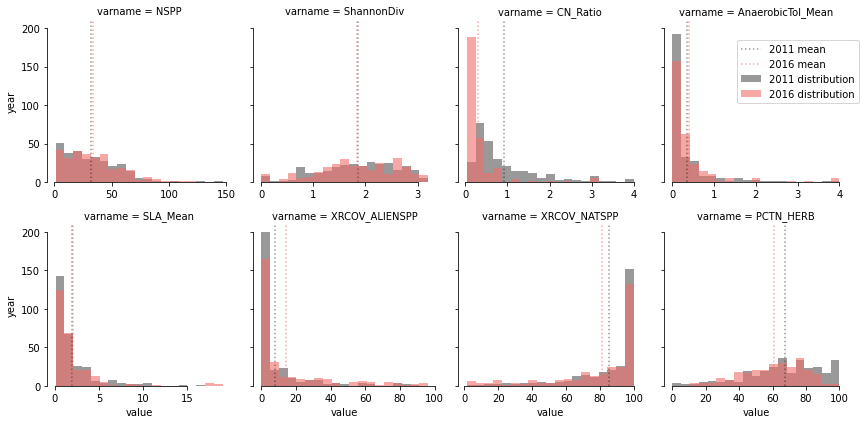

In [ ]:
vars_to_plot = [
        "NSPP", "ShannonDiv", 
        "CN_Ratio", #"CN_Variance", 
        "AnaerobicTol_Mean", #"AnaerobicTol_Variance", 
        "SLA_Mean", #"SLA_Variance", 
        #"XN_ALIENSPP", 
        "XRCOV_ALIENSPP", 
        #"XN_NATSPP", 
        "XRCOV_NATSPP", 
        "PCTN_HERB", 
]

def plot_hist_grouped(x, hue, n_bins=10, color=None, palette=None, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    for i, (_, x_i) in enumerate(x.groupby(hue)):
        x_mean = x_i.mean()
        #x_std = np.std(x_i)
        #x_ci_low = x_mean - x_std
        #x_ci_high = x_mean + x_std
        if palette:
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1, color=palette[i])
            plt.hist(x_i, bins, color=palette[i], **kwargs)
            plt.axvline(x=x_mean, linestyle=":", color=palette[i])
        else:
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1)
            plt.hist(x_i, bins, **kwargs)
            plt.axvline(x=x_mean, linestyle=":")


d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        [vars_to_plot]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year"])
        )
g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False)
g.map(plot_hist_grouped, "value", "year", n_bins=20, palette=["#00000066", "#EF6F6A99"])
#g.add_legend()
g.fig.legend(["2011 mean", "2016 mean", "2011 distribution", "2016 distribution"]).set_bbox_to_anchor((1, 0.9))
sns.despine(trim=True)
plt.show()

# imrpovement: kde histograms, colored by wetland type, rows=year, columns=vars

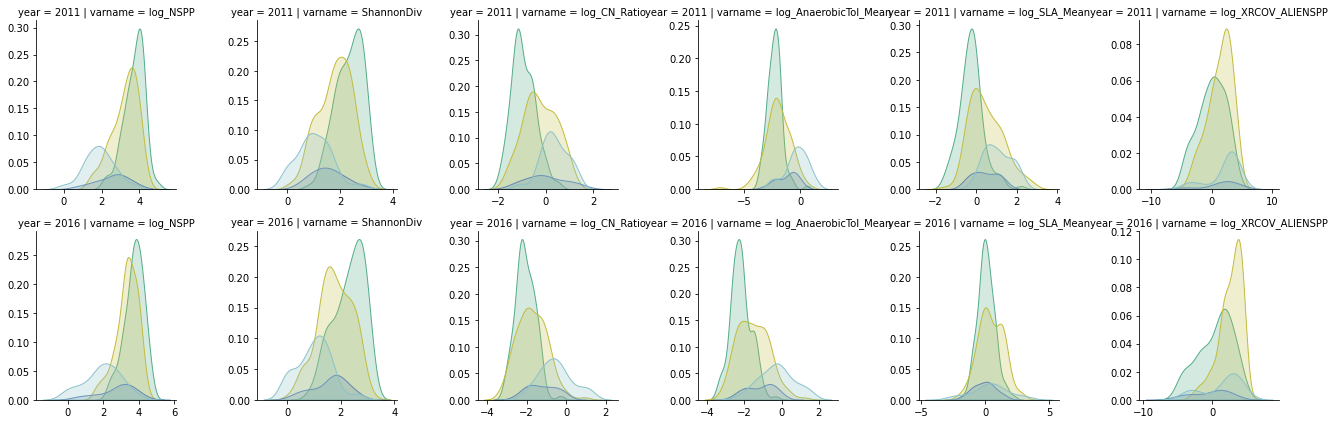

In [ ]:
vars_to_plot2 = ["log_NSPP", "ShannonDiv", "log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean", "log_XRCOV_ALIENSPP"]
d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot2]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot2)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", row="year", sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat", palette=catcolors, shade=True)
g.add_legend()
sns.despine()
#for a in g.axes.flatten():
#    a.set_xticks(np.exp(a.get_xticks()[:-2]))
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )
# update to use proper category order

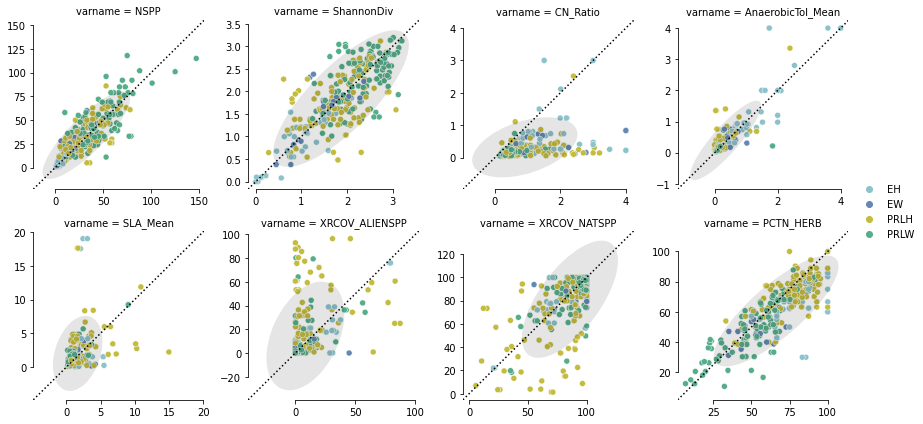

In [ ]:
def plot_twoway_symmetrical(*args, **kwargs):
    sp = sns.scatterplot(*args, **kwargs)
    ax = sp.axes
    if "data" in kwargs:
        x = kwargs["data"][kwargs["x"]]
        y = kwargs["data"][kwargs["y"]]
    else:
        x = kwargs["x"]
        y = kwargs["y"]
    ax.add_patch(make_ellipse(x=x, y=y, 
        facecolor="black", alpha=0.1, type="error", n_std=2))
    std_min = min(ax.get_xlim() + ax.get_ylim())
    std_max = max(ax.get_xlim() + ax.get_ylim())
    std_lim = (std_min, std_max)
    ax.set_xlim(std_lim)
    ax.set_ylim(std_lim)
    #ax.set_xticks(ax.get_yticks(minor=False), minor=False)
    #ax.set_xticklabels(ax.get_xticklabels(minor=False), minor=False)
    sns.lineplot(ax=ax, color="black", linestyle=":", x=std_lim, y=std_lim)
    sns.despine(trim=True, ax=ax)
    return sp

d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot]
        .unstack("year")
        .stack("varname")
        .reset_index(["varname", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(plot_twoway_symmetrical, x="2011", y="2016", hue="WetlandCat", ci=False, palette=catcolors)
g.add_legend()
#map(lambda a: a.set_xlim(0), g.axes)
#map(lambda a: a.set_ylim(0), g.axes)
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )
# update to use proper category order

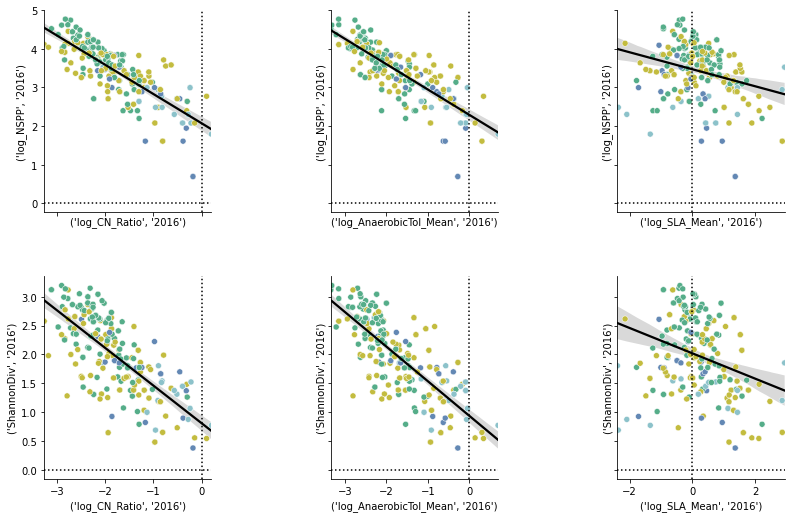

In [ ]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

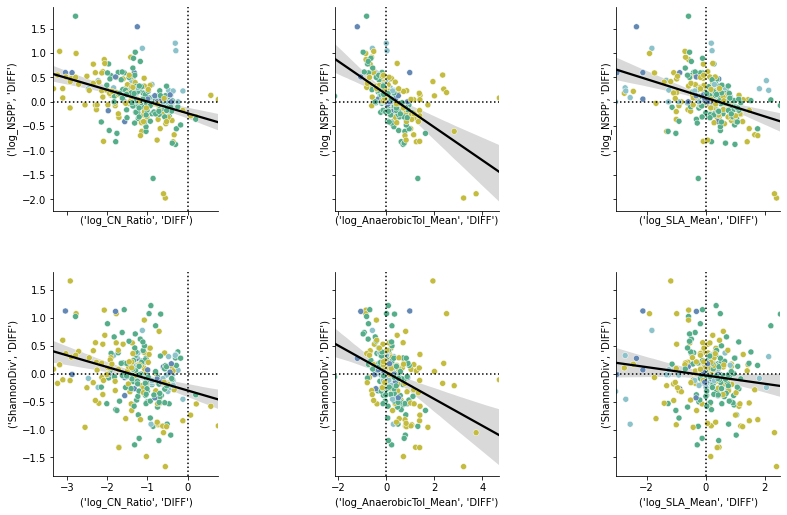

In [ ]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

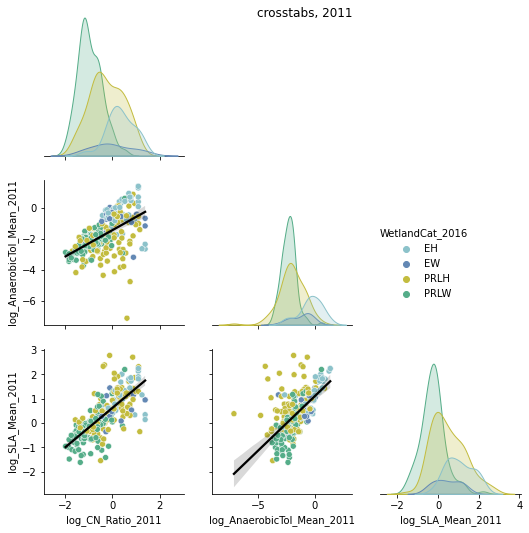

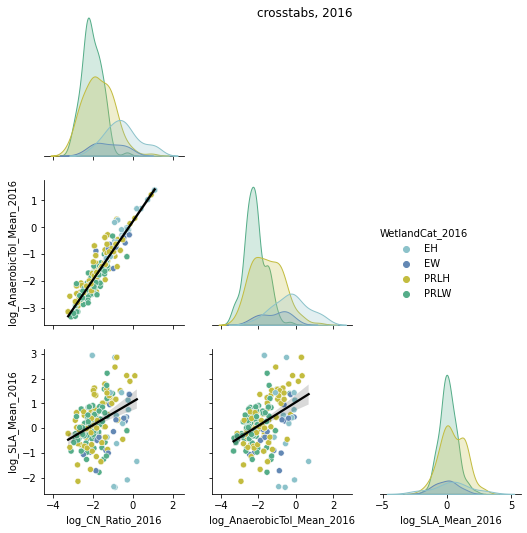

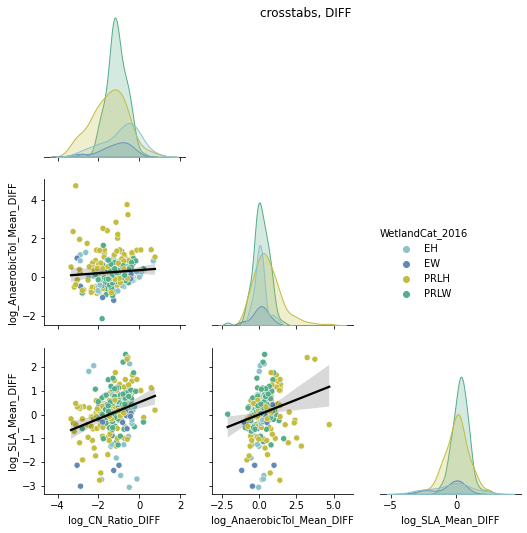

In [ ]:
#def plot_diag(*args, **kwargs):
#    g = sns.kdeplot(*args, **kwargs)
#    g.axes.axvline(x=0, color="black", linestyle=":")
#    return g

def plot_offdiag(hue, palette, *args, **kwargs):
    g = sns.scatterplot(x=kwargs["x"], y=kwargs["y"], hue=hue, palette=palette)
    h = sns.regplot(x=kwargs["x"], y=kwargs["y"], scatter=False, ax=g.axes, color="black")
#    g.axes.axhline(y=0, color="black", linestyle=":")
#    g.axes.axvline(x=0, color="black", linestyle=":")
    return g

for yr in ["2011", "2016", "DIFF"]:
    d = flatten_columns(sites)[["WetlandCat_2016", f"log_CN_Ratio_{yr}", f"log_AnaerobicTol_Mean_{yr}", f"log_SLA_Mean_{yr}"]] #, f"log_NSPP_{yr}", f"ShannonDiv_{yr}"]] #.dropna()
    #g = sns.pairplot(d, corner=True, kind="scatter", diag_kind="kde", hue="WetlandCat_2016", palette=catcolors)
    g = sns.PairGrid(d, corner=True, hue="WetlandCat_2016")
#    g.map_diag(plot_diag, hue=d["WetlandCat_2016"], palette=catcolors, fill=True)
    g.map_diag(sns.kdeplot, hue=d["WetlandCat_2016"], palette=catcolors, fill=True)
    g.map_offdiag(plot_offdiag, hue=d["WetlandCat_2016"], palette=catcolors)
    g.fig.suptitle(f"crosstabs, {yr}")
    g.add_legend()
    g._legend.set_bbox_to_anchor(((3/4), (1/2)))
    plt.show()
# note high correlation between anaerobic tol and CN ratio in 2016

NSPP_DIFF
               count  mean   std    min   25%  50%   75%   max
REF_NWCA_2011                                                 
L              51.00  0.14 10.93 -29.00 -2.50 0.00  4.00 43.00
I             139.00  3.27 14.51 -46.00 -2.00 2.00 12.00 48.00
M              99.00  0.11 11.23 -33.00 -4.50 0.00  6.00 29.00
ShannonDiv_DIFF
               count  mean  std   min   25%   50%  75%  max
REF_NWCA_2011                                              
L              51.00 -0.04 0.40 -0.96 -0.28 -0.02 0.20 1.04
I             139.00 -0.01 0.48 -1.32 -0.25 -0.03 0.24 1.22
M              99.00 -0.05 0.56 -1.66 -0.39  0.04 0.21 1.66


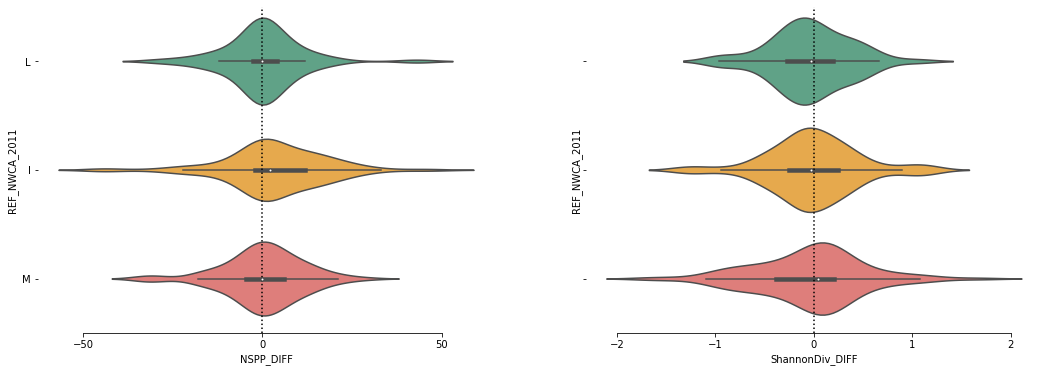

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True)
palette = ["#55AD89", "#FFAE34", "#EF6F6A"]
sns.violinplot(data=flatten_columns(sites), x="NSPP_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[0])
sns.violinplot(data=flatten_columns(sites), x="ShannonDiv_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[1])
ax[0].axvline(0, c="black", ls=":")
ax[1].axvline(0, c="black", ls=":")
sns.despine(trim=True, left=True)
fig.set_size_inches(18,6)

print("NSPP_DIFF")
print(flatten_columns(sites).groupby("REF_NWCA_2011")["NSPP_DIFF"].describe())
print("ShannonDiv_DIFF")
print(flatten_columns(sites).groupby("REF_NWCA_2011")["ShannonDiv_DIFF"].describe())

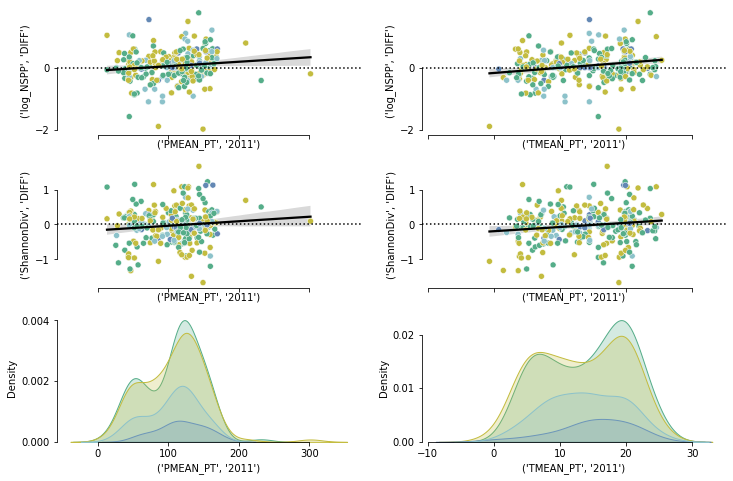

In [ ]:
# temperature and precipitation

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["PMEAN_PT", "TMEAN_PT"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars) + 1, len(x_vars), sharex="col", sharey=False)
for j, x in enumerate(x_vars):
    for i, y in enumerate(y_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
    sns.kdeplot(ax=axs[-1, j], x=d[(x, "2011")], hue=d[("WetlandCat", "2016")], palette=catcolors, legend=False, shade=True)
sns.despine(trim=True)
#plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

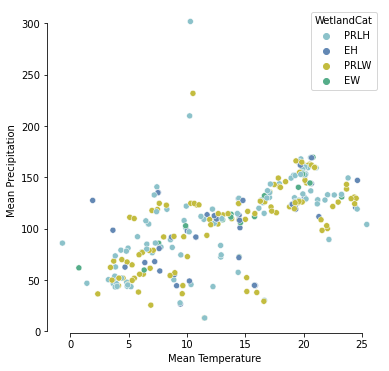

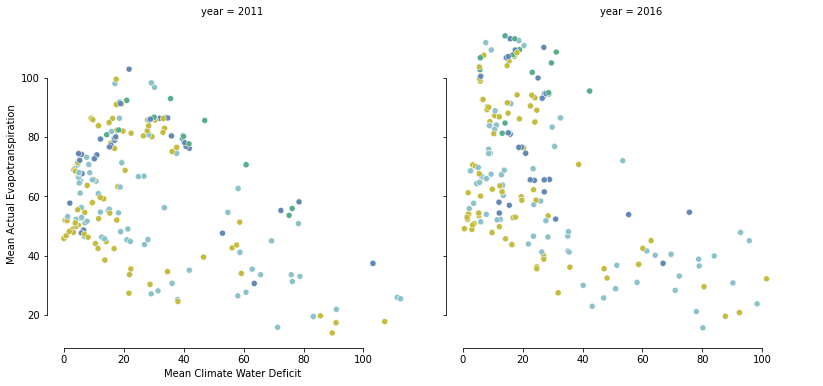

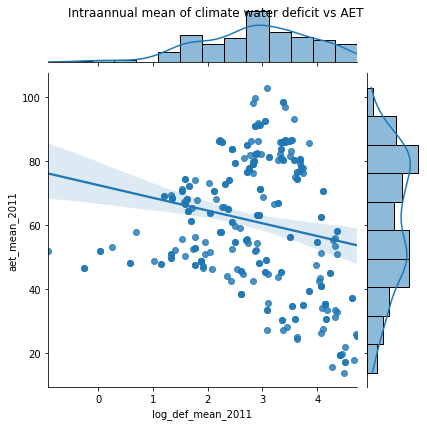

In [ ]:
d = sites.stack("year").loc[idx[:, :, "2011"]]
fig, ax = plt.subplots()
sns.scatterplot(data=d, x="TMEAN_PT", y="PMEAN_PT", hue="WetlandCat", palette=catcolors, ax=ax)
ax.set(xlabel="Mean Temperature", ylabel="Mean Precipitation")
fig.set_size_inches(6,6)
sns.despine(trim=True)
plt.show()

d = sites.stack("year").query("year=='2011' | year=='2016'").reset_index("year")
g = sns.FacetGrid(data=d, col="year")
g.map_dataframe(sns.scatterplot, x="def_mean", y="aet_mean", hue="WetlandCat", palette=catcolors)
g.axes[0,0].set(xlabel="Mean Climate Water Deficit", ylabel="Mean Actual Evapotranspiration")
g.fig.set_size_inches(12,6)
sns.despine(trim=True)
plt.show()

#   for yr in [2011, 2016]:
#       g = sns.jointplot(data=flatten_columns(sites), x=f"def_mean_{yr}", y=f"aet_mean_{yr}", hue=f"WetlandCat_{yr}", palette=catcolors, ax=ax)
#       g.ax_joint.set(xlabel="Climate Water Deficit", ylabel="Actual Evapotranspiration")
#       fig.set_size_inches(12,12)
#       sns.despine(trim=True)
#       plt.show()
#   
#   a = sns.kdeplot(data=flatten_columns(sites), x="def_mean_DIFF", hue="WetlandCat_2016", palette=catcolors, shade=True)
#   a.set_title("$\Delta$ Climate Water Deficit")
#   a.axvline(x=0, color="black", ls=":")
#   sns.despine()

#   g = sns.jointplot(data=flatten_columns(sites), x="def_mean_DIFF", y="aet_mean_DIFF", hue="WetlandCat_2016", palette=catcolors, ax=ax)
#   g.ax_joint.set(xlabel="$\Delta$ Climate Water Deficit", ylabel="$\Delta$ Actual Evapotranspiration")
#   g.ax_joint.axvline(x=0, color="black", ls=":")
#   g.ax_joint.axhline(y=0, color="black", ls=":")
#   g.ax_marg_x.axvline(x=0, color="black", ls=":")
#   g.ax_marg_y.axhline(y=0, color="black", ls=":")
#   fig.set_size_inches(12,12)
#   sns.despine(trim=True)
#   plt.show()

g = sns.jointplot(data=flatten_columns(sites), x="log_def_mean_2011", y="aet_mean_2011", kind="reg")
g.fig.suptitle("Intraannual mean of climate water deficit vs AET")
plt.show()

#   g = sns.jointplot(data=flatten_columns(sites), x="def_max_2011", y="aet_max_2011", kind="reg")
#   g.fig.suptitle("Intraannual maximum climate water deficit vs AET")
#   plt.show()
#   
#   g = sns.jointplot(data=flatten_columns(sites), x="def_std_2011", y="aet_std_2011", kind="reg")
#   g.fig.suptitle("Intraannual variation in climate water deficit vs AET")
#   plt.show()
#   
#   g = sns.jointplot(data=flatten_columns(sites), x="def_mean_DIFF", y="aet_mean_DIFF", kind="reg")
#   g.fig.suptitle("2011-2016 change in climate water deficit vs AET")
#   plt.show()

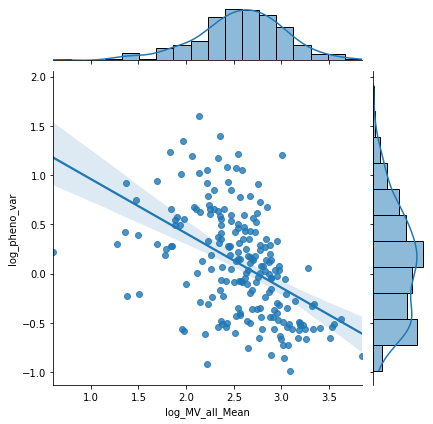

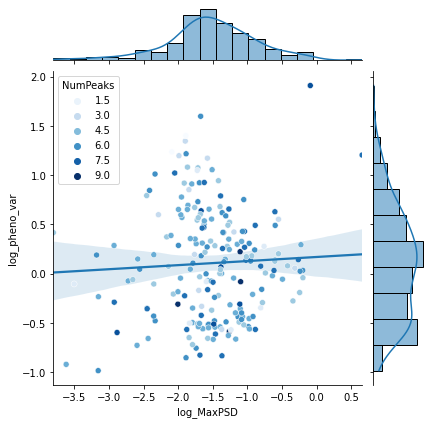

In [ ]:
d = flatten_columns(sites)

sns.jointplot(data=d, x="log_MV_all_Mean", y="log_pheno_var", kind="reg")
plt.show()

g = sns.jointplot(data=d, y="log_pheno_var", x="log_MaxPSD", kind="reg", scatter=False)
sns.scatterplot(data=d, y="log_pheno_var", x="log_MaxPSD", hue="NumPeaks", ax=g.ax_joint, palette="Blues")
plt.show()

# Exploratory regression (diversity)


                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.582   
Dependent Variable:    log_NSPP_DIFF       AIC:                   106.9422
Date:                  2021-07-16 19:46    BIC:                   170.9652
No. Observations:      259                 Log-Likelihood:        -35.471 
Df Model:              17                  F-statistic:           15.34   
Df Residuals:          241                 Prob (F-statistic):    1.25e-29
R-squared:             0.610               Scale:                 0.082749
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.9337   0.1703 -5.4828 0.0000 -1.2675 -0.6000
log_CN_Ratio_DIFF          -0.3104   0.0503 -6.1667 0.0000 -0.4090 -0.2117
log_AnaerobicTol_Mean_DIFF -0.2677   0.0375 -

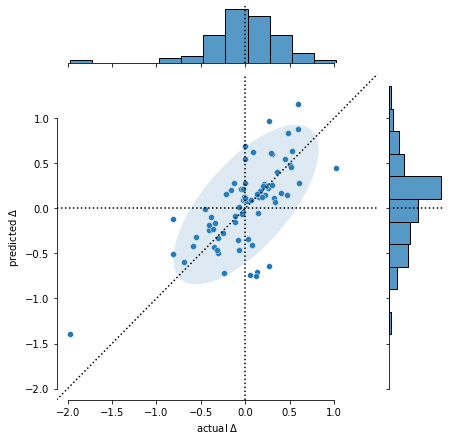

In [ ]:
f = """log_NSPP_DIFF ~ 
                            log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF
"""
d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")

print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()


                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.224   
Dependent Variable:    ShannonDiv_DIFF     AIC:                   338.7903
Date:                  2021-07-16 19:45    BIC:                   402.8132
No. Observations:      259                 Log-Likelihood:        -151.40 
Df Model:              17                  F-statistic:           6.639   
Df Residuals:          241                 Prob (F-statistic):    6.43e-13
R-squared:             0.275               Scale:                 0.20255 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.6724   0.2674 -2.5143 0.0119 -1.1966 -0.1483
log_CN_Ratio_DIFF          -0.3268   0.0694 -4.7083 0.0000 -0.4629 -0.1908
log_AnaerobicTol_Mean_DIFF -0.1660   0.0573 -

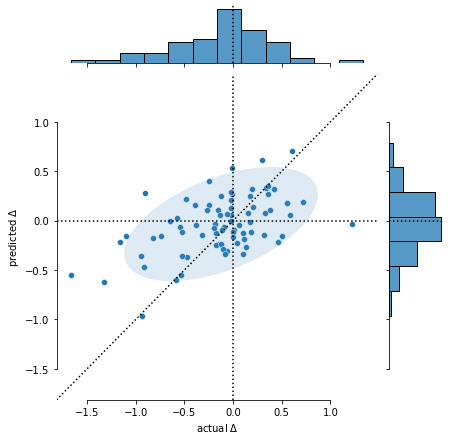

In [ ]:
f = """ShannonDiv_DIFF ~ 
                            log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF
"""

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")
print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()


                      Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.355    
Dependent Variable:     MV_all_Mean        AIC:                  1171.5472
Date:                   2021-07-16 19:53   BIC:                  1252.0561
No. Observations:       185                Log-Likelihood:       -560.77  
Df Model:               24                 F-statistic:          6.844    
Df Residuals:           160                Prob (F-statistic):   8.81e-15 
R-squared:              0.439              Scale:                29.070   
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  12.3004   4.7437  2.5930 0.0095  3.0029 21.5979
log_NSPP_DIFF              -2.3144   1.6533 -1.3999 0.1615 -5.5547  0.9259
ShannonDiv_DIFF             0.6884   0.8509  

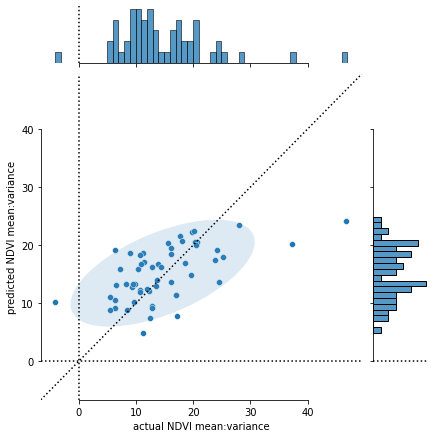

In [ ]:
f = """MV_all_Mean ~ 
                            log_NSPP_DIFF + ShannonDiv_DIFF + SLA_Variance_DIFF
                            + log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF 
                            + aet_std + def_std
                            + NumPeaks + MaxPSD
"""

d = flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")
print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=1))
g.ax_joint.set_xlabel("actual NDVI mean:variance")
g.ax_joint.set_ylabel("predicted NDVI mean:variance")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()


                       Results: Ordinary least squares
Model:                  OLS                 Adj. R-squared:        0.565   
Dependent Variable:     log_pheno_var       AIC:                   179.6788
Date:                   2021-07-16 20:10    BIC:                   260.1877
No. Observations:       185                 Log-Likelihood:        -64.839 
Df Model:               24                  F-statistic:           17.80   
Df Residuals:           160                 Prob (F-statistic):    1.02e-33
R-squared:              0.622               Scale:                 0.13646 
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   0.9112   0.3168   2.8761 0.0040  0.2902  1.5322
log_NSPP_DIFF               0.0420   0.1024   0.4105 0.6814 -0.1586  0.2427
ShannonDiv_DIFF            -0.00

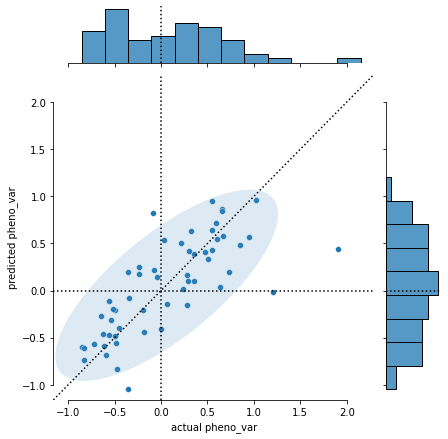

In [ ]:
f = """log_pheno_var ~ 
                            log_NSPP_DIFF + ShannonDiv_DIFF + SLA_Variance_DIFF
                            + log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF 
                            + aet_std + def_std
                            + NumPeaks + log_MaxPSD
"""

d = flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")
print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual pheno_var")
g.ax_joint.set_ylabel("predicted pheno_var")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()

# regression output (diversity) with different sets of variables

In [626]:
def exec_ols(y: pd.Series, X: pd.DataFrame, standardize=True):
    dmat = pd.concat([y, X], axis="columns").dropna()
    if standardize:
        dmat[:] = scale(dmat[:]) # standardize the variables and don't fit intercept
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:]).fit(covtype="HC0")
    else:
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:].assign(intercept=1)).fit(covtype="HC0")
    return reg #(reg.rsquared_adj, reg.params, reg.pvalues)

def fit_models(df: pd.DataFrame, ys: list, Xs: dict) -> pd.DataFrame:
    regs = [[exec_ols(y = df[y], X = df[Xs[m]]) for m in Xs] for y in ys]
    regs = pd.DataFrame(regs, index=ys, columns=Xs).stack().rename("model")
    return regs

def output_results(regs: pd.Series) -> pd.DataFrame:

    rsquareds = regs.apply(lambda x: x.rsquared).rename_axis(["y", "model"])
    params = regs.apply(lambda x: x.params).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    pvalues = regs.apply(lambda x: x.pvalues).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    
    # pretty print
    params = params.applymap(lambda x: f"+{abs(x):0.2f}" if x>0 else f"−{abs(x):0.2f}" if x<0 else "—" if x==0 else "").applymap(lambda x: "" if x=="nan" else x)
    #pvalues = pvalues.applymap(lambda x: f"**{x:0.2f}" if x<0.05 else f"{x:0.2f}").applymap(lambda x: "" if x=="nan" else x)
    pvalues = pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "").applymap(lambda x: "" if x=="nan" else x)

    if "intercept" in params.columns:
        varnames = list(params.columns.drop("intercept")) + ["intercept"] + ["_outputs"]
    else:
        varnames = list(params.columns) + ["_outputs"]
    varnames_dtype = pd.CategoricalDtype(categories=reversed(varnames), ordered=True)
    params.columns = params.columns.astype(varnames_dtype)
    pvalues.columns = pvalues.columns.astype(varnames_dtype)

    return (pd.concat([params.T.assign(output="coeff"), 
                pvalues.T.assign(output="P"), 
                pd.DataFrame(rsquareds.rename("_outputs")).T.assign(output="R2_adj")])
            .set_index(["output"], append=True)
            .sort_index(level=0, ascending=False)
            .fillna("")
            )

def test_vif(df, Xs, sqrt=True):
    def quick_vif(d):
        v = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
        return pd.Series(v, index = d.columns)
    vif = pd.DataFrame({k: quick_vif(df[Xs[k]].dropna()) for k in Xs})
    vif = vif.reindex(vif.max(axis="columns").sort_values(ascending=False).index)
    if sqrt:
        return np.sqrt(vif)
    else:
        return vif

def test_sked(regs):
    s = regs.apply(lambda m: het_breuschpagan(m.resid, m.model.exog))
    hbp = pd.DataFrame.from_dict(dict(zip(s.index, s.values)))
    hbp.index = ["LMS", "P(LMS)", "F", "P(F)"]
    return hbp

#   def test_moran(df, ys):
#       return (df[ys]
#           .select_dtypes("number")
#           .apply(lambda s: Moran(s, w))
#           .apply(lambda x: {"I":x.I, "P":x.p_norm})
#           .apply(lambda x:pd.Series(x))
#           .sort_values("I", ascending=False)
#           .dropna()
#       )

In [648]:
# dependent variables for models of taxonomic diversity
vars_dif_taxo_div = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]

# groups of x variables used in diversity models
vars_dif_traits = ["log_SLA_Mean_DIFF", "log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF"]
vars_dif_native = ["XRCOV_NATSPP_DIFF"]
vars_dif_climate = ["def_mean_DIFF"] # "PDSI_mean_DIFF", 
vars_climate = ["aet_mean", "def_mean"] 
#vars_climate = ["PMEAN_PT_2011", "TMEAN_PT_2011"]
vars_disturb = ["d_disturb_I_2011", "d_disturb_M_2011"]
vars_attributes = ["d_estuarine_2011", "d_woody_2011"]
vars_traits_prev = ["CN_prevalence_2016", "AnTol_prevalence_2016", "SLA_prevalence_2016"]

# order of models to test
dmodels = {
        "d1": vars_attributes + vars_climate + vars_dif_climate,
        "d2": vars_attributes + vars_climate + vars_dif_climate + vars_dif_traits,
        "d3": vars_attributes + vars_climate + vars_dif_climate + vars_dif_traits + vars_traits_prev,
        "d4": vars_attributes + vars_climate + vars_dif_climate + vars_dif_traits + vars_traits_prev + vars_dif_native + vars_disturb,
        "d5": vars_dif_traits
        }

# dependent variables for models of diversity
vars_stability = ["MV_all_Mean", "MV_all_Max", "log_pheno_var"]

# groups of x variables (in addition to groups previously defined)
vars_stab_ts = ["NumPeaks", "log_MaxPSD"]
vars_dif_func_div = ["SLA_Variance_DIFF"]
vars_climate_variability = ["aet_std", "def_std"]

# order of models to test
smodels = {
        "s1": vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate,
        "s2": vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_stab_ts,
        "s3": vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_dif_taxo_div + vars_dif_func_div,
        "s4": vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_stab_ts + vars_dif_taxo_div + vars_dif_func_div,
        "s5": vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_stab_ts + vars_dif_taxo_div + vars_dif_func_div + vars_dif_native + vars_disturb,
        "s5": vars_stab_ts,
        "s6": vars_stab_ts + vars_dif_taxo_div + vars_dif_func_div,
        }

df = flatten_columns(sites)

In [649]:
regs_diversity = fit_models(df=df, ys=vars_dif_taxo_div, Xs=dmodels)
print("\n", "multicollinearity test (root VIF)")
print(test_vif(df, dmodels, sqrt=True)) # root VIF > 4 (rule of thumb) indicates collinearity
print("\n", "heteroskedasticity test (LMS)")
print(test_sked(regs_diversity).T) # significant LMS indicates heteroskedasticity
print("\n", "regression results")
output_results(regs_diversity)


 multicollinearity test (root VIF)
                             d1   d2   d3   d4   d5
aet_mean                   1.82 2.51 4.05 4.24  nan
CN_prevalence_2016          nan  nan 3.84 3.94  nan
AnTol_prevalence_2016       nan  nan 3.85 3.92  nan
SLA_prevalence_2016         nan  nan 2.97 2.99  nan
log_CN_Ratio_DIFF           nan 2.12 2.70 2.73 1.04
d_disturb_I_2011            nan  nan  nan 2.12  nan
d_disturb_M_2011            nan  nan  nan 1.89  nan
def_mean                   1.28 1.55 1.78 1.83  nan
d_woody_2011               1.39 1.52 1.54 1.61  nan
log_SLA_Mean_DIFF           nan 1.12 1.34 1.34 1.03
d_estuarine_2011           1.26 1.28 1.32 1.33  nan
log_AnaerobicTol_Mean_DIFF  nan 1.17 1.22 1.24 1.06
def_mean_DIFF              1.04 1.05 1.19 1.22  nan
XRCOV_NATSPP_DIFF           nan  nan  nan 1.08  nan

 heteroskedasticity test (LMS)
                     LMS  P(LMS)    F  P(F)
log_NSPP_DIFF   d1  7.86    0.10 1.59  0.16
                d2 17.41    0.01 2.26  0.02
                d3 1

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                        d1     d2  ...              d4     d5
                           output                       ...                       
d_estuarine_2011           coeff          +0.04  +0.08  ...           +0.02       
                           P                            ...                       
d_woody_2011               coeff          +0.01  −0.09  ...           +0.03       
                           P                         *  ...                       
aet_mean                   coeff          +0.05  +0.09  ...           −0.05       
                           P                            ...                       
def_mean                   coeff          +0.15  +0.15  ...           −0.11       
                           P                 **     **  ...                       
def_mean_DIFF              coeff          −0.03  +0.08  ...           +0.03       
                           P                            ...                       
log_SLA_Mean_DIFF          coeff                 −0.15  ...           +0.11  +0.00
                           P                       ***  ...                       
log_CN_Ratio_DIFF          coeff                 −0.27  ...           −0.48  −0.26
                           P                       ***  ...             ***    ***
log_AnaerobicTol_Mean_DIFF coeff                 −0.55  ...           −0.26  −0.33
                           P                       ***  ...             ***    ***
CN_prevalence_2016         coeff                        ...           +0.17       
                           P                            ...               *       
AnTol_prevalence_2016      coeff                        ...           +0.08       
                           P                            ...                       
SLA_prevalence_2016        coeff                        ...           −0.19       
                           P                            ...              **       
XRCOV_NATSPP_DIFF          coeff                        ...           +0.10       
                           P                            ...               *       
d_disturb_I_2011           coeff                        ...           +0.02       
                           P                            ...                       
d_disturb_M_2011           coeff                        ...           +0.10       
                           P                            ...                       
_outputs                   R2_adj          0.02   0.52  ...            0.26   0.20

[29 rows x 10 columns]

In [650]:
regs_stability = fit_models(df=df, ys=vars_stability, Xs=smodels)
print("\n", "multicollinearity test (root VIF)")
print(test_vif(df, smodels, sqrt=True)) # root VIF > 2 (rule of thumb) indicates collinearity
print("\n", "heteroskedasticity test (LMS)")
print(test_sked(regs_stability).T) # significant LMS indicates heteroskedasticity
print("\n", "regression results")
output_results(regs_stability)


 multicollinearity test (root VIF)
                    s1   s2   s3   s4   s5   s6
def_std           5.63 5.69 5.63 5.71  nan  nan
def_mean          4.60 4.94 4.61 4.98  nan  nan
aet_std           3.78 4.43 3.79 4.44  nan  nan
aet_mean          4.15 4.28 4.15 4.29  nan  nan
NumPeaks           nan 3.23  nan 3.30 2.04 2.12
log_MaxPSD         nan 3.13  nan 3.15 2.04 2.08
d_woody_2011      1.39 1.42 1.41 1.44  nan  nan
d_estuarine_2011  1.35 1.36 1.35 1.36  nan  nan
def_mean_DIFF     1.23 1.28 1.23 1.28  nan  nan
log_NSPP_DIFF      nan  nan 1.20 1.24  nan 1.21
ShannonDiv_DIFF    nan  nan 1.18 1.21  nan 1.19
SLA_Variance_DIFF  nan  nan 1.12 1.14  nan 1.12

 heteroskedasticity test (LMS)
                   LMS  P(LMS)    F  P(F)
MV_all_Mean   s1 22.57    0.00 3.50  0.00
              s2 22.63    0.00 2.70  0.01
              s3 25.39    0.00 2.76  0.00
              s4 25.71    0.01 2.31  0.01
              s5  2.70    0.10 1.36  0.26
              s6  4.23    0.38 0.84  0.52
MV_all_Max    

y                        MV_all_Mean                ... log_pheno_var              
model                             s1     s2     s3  ...            s4     s5     s6
                  output                            ...                            
d_estuarine_2011  coeff        −0.07  −0.07  −0.07  ...         +0.07              
                  P                                 ...                            
d_woody_2011      coeff        +0.24  +0.24  +0.23  ...         −0.10              
                  P              ***    ***    ***  ...             *              
aet_mean          coeff        +0.57  +0.57  +0.57  ...         −0.95              
                  P              ***    ***    ***  ...           ***              
def_mean          coeff        +0.16  +0.16  +0.12  ...         −0.59              
                  P                                 ...           ***              
aet_std           coeff        −0.28  −0.28  −0.29  ...         +0.41              
                  P              ***    ***    ***  ...           ***              
def_std           coeff        −0.26  −0.26  −0.22  ...         +0.47              
                  P                                 ...           ***              
def_mean_DIFF     coeff        +0.33  +0.32  +0.31  ...         −0.31              
                  P              ***    ***    ***  ...           ***              
NumPeaks          coeff               −0.02         ...         −0.09  −0.11  −0.10
                  P                                 ...             *              
log_MaxPSD        coeff               −0.00         ...         +0.28  +0.06  +0.06
                  P                                 ...           ***              
log_NSPP_DIFF     coeff                      −0.10  ...         +0.03         −0.03
                  P                                 ...                            
ShannonDiv_DIFF   coeff                      −0.03  ...         +0.02         +0.07
                  P                                 ...                            
SLA_Variance_DIFF coeff                      +0.06  ...         −0.02         −0.06
                  P                                 ...                            
_outputs          R2_adj        0.33   0.33   0.34  ...          0.55   0.02   0.02

[25 rows x 18 columns]

# Model selection 

Use cross validation to test models with all possible combinations of vars

Note: There are $\sum_{k=1}^{n} {n\choose k} = 2^n$ possible combos for $n$ variables, so there is an upper limit to the number of variables to test this way in any reasonable amount of time

In [ ]:
# disable for now because this is computationally expensive
if False:

    from itertools import combinations
    from sklearn.model_selection import train_test_split, cross_validate
    from sklearn.model_selection import KFold

    cv = KFold(n_splits=3, shuffle=True, random_state=47) # KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, etc.
    scoring = ["r2", "neg_root_mean_squared_error", "neg_median_absolute_error"]

    models = {
        "OLS": LinearRegression(fit_intercept=True, normalize=True, copy_X=True),
    }

    y_vars = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]
    X_vars = ["log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF", "log_XRCOV_ALIENSPP_DIFF",
              "CN_prevalence_2016", "AnTol_prevalence_2016", "SLA_prevalence_2016",
              "d_estuarine_2016", "d_woody_2016",
              "d_disturb_I_2011", "d_disturb_M_2011",
              "PMEAN_PT_2011", "TMEAN_PT_2011",
              "aet_mean_2011", "def_mean_2011",
              ]
    X_combos = reduce(lambda x, y: x + y, [list(combinations(X_vars, r=i)) for i in range(1, len(X_vars) + 1)])
    print(f"testing {len(X_combos)} combinations of {len(X_vars)} variables with {len(models)} models")

    for y_var in y_vars:

        print("\n", y_var)
        df = flatten_columns(sites)[[y_var] + X_vars].dropna()

        out = {}
        for m in models:
            for c in X_combos:
                selected_vars = list(c)
                y = df[y_var]
                X = df[selected_vars]
                scores = cross_validate(models[m], X, y, cv=cv, scoring=scoring, return_train_score=False)
                out[(m, c)] = scores

        cv_means = pd.DataFrame(out).rename_axis("metric", axis=0).rename_axis(["model", "variables"], axis=1).T.applymap(np.mean)
        cv_means_scored = cv_means.sort_values("test_neg_root_mean_squared_error", ascending=False)
        print(cv_means_scored["test_neg_root_mean_squared_error"].head(20)) # these are the best-scoring model combinations

        # run OLS with the best-scoring model combination
        best_X_vars = list(cv_means_scored.index[0][1])
        results = sm.OLS(endog=df[y_var], exog=df[best_X_vars]).fit(cov_type="HC0")
        print(results.summary2())

# test for spatial autocorrelation

In [ ]:
# Moran's I for spatial autocorrelation

#   # random array for testing
#   Z = np.random.rand(3,2)
#   # create weight matrix
#   w = lat2W(Z.shape[0], Z.shape[1])
#   # for xarray, can create 
#   # from libpysal.weights import Queen
#   # Queen.from_xarray()
#   # calculate Moran's I
#   mi = Moran(Z, w)
#   # print("I=", mi.I, "P=", mi.p_norm)

# nearest neighbor weights
#   w = KNN.from_dataframe(sites_gdf)
#   mi = Moran(sites_gdf[("NSPP", "2011")], w)
#   print("I=", mi.I, "P=", mi.p_norm)

# Apply to DataFrame:
(sites_gdf
        .pipe(flatten_columns)
        .select_dtypes("number")
        .apply(lambda s: Moran(s, w))
        .apply(lambda x: {"I":x.I, "P":x.p_norm})
        .apply(lambda x:pd.Series(x))
        .sort_values("I", ascending=False)
        .dropna()
)

# see http://darribas.org/gds15/content/labs/lab_06.html
# see https://splot.readthedocs.io/en/stable/users/tutorials/weights.html#distance-based-weights 

,I,P
Longitude_2016,1.00,0.00
Longitude_2011,1.00,0.00
Latitude_2011,0.98,0.00
Latitude_2016,0.98,0.00
FREQ_EXPOSED_GRAVEL_2011,0.70,0.00
d_estuarine_2016,0.62,0.00
d_estuarine_2011,0.62,0.00
N_ANNUAL_2011,0.61,0.00
CN_Ratio_DIFF,0.60,0.00
N_GRAMINOID_2011,0.55,0.00
